In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = '../portfolio/plots/'
datadir='../data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv(datadir+'a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv(datadir+'b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv(datadir+'s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

## Simulations

In [2]:
simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

policies = [cp.PeriodicRebalance(target=w_b, period=p) for p in ['day', 'week', 'month', 'quarter', 'year']]
policies.append(cp.Hold())

res = pd.DataFrame(index=['Daily','Weekly','Monthly','Quarterly','Annually','Hold'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multiple_backtest(fund_val*w_b, start_time=start_t, end_time=end_t, 
                                                 policies=policies, parallel=True)

## Results 

In [4]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=np.dot(used_returns.values, w_b.values))

table=pd.DataFrame()
table[r'Active return']=res.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Active risk']= \
    res.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Trans. costs']=\
    res.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Turnover']= \
    res.applymap(lambda res: res.turnover.mean()*100.*250.).unstack()


table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{llllll}
\toprule
       &       & Active return & Active risk & Trans. costs & Turnover \\
\midrule
\$100M & Daily &        -0.07\% &       0.00\% &        0.07\% &  220.53\% \\
       & Weekly &        -0.07\% &       0.09\% &        0.04\% &  105.67\% \\
       & Monthly &        -0.12\% &       0.21\% &        0.02\% &   52.71\% \\
       & Quarterly &        -0.11\% &       0.35\% &        0.01\% &   29.98\% \\
       & Annually &        -0.10\% &       0.63\% &        0.01\% &   12.54\% \\
       & Hold &        -0.36\% &       1.53\% &        0.00\% &    0.00\% \\
\$10B & Daily &        -0.25\% &       0.01\% &        0.25\% &  220.53\% \\
       & Weekly &        -0.19\% &       0.09\% &        0.16\% &  105.67\% \\
       & Monthly &        -0.20\% &       0.21\% &        0.10\% &   52.71\% \\
       & Quarterly &        -0.17\% &       0.35\% &        0.07\% &   29.99\% \\
       & Annually &        -0.13\% &       0.63\% &        0.04\% &   12.54\% \\
       &

# Plots 

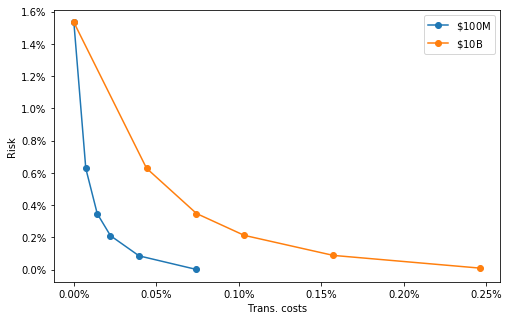

In [6]:
plt.figure(figsize=(8,5))
for v1 in table.index.levels[0][:]:
    x = table.loc[v1]['Trans. costs']
    y = table.loc[v1]['Active risk']
    plt.plot(np.array(x),np.array(y), 'o-', label='$%s\mathrm{%s}$'%(v1[:-1],v1[-1:]))
plt.legend(loc='upper right')
plt.xlabel('Trans. costs')
plt.ylabel('Risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
#plt.savefig(plotdir+'basic_frontier.png')